## Library imports

In [2]:
!pip install augmax
# Install the newest JAXlib version.
!pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
#!pip install --upgrade -q pip jax jaxlib
# Install Flax at head:
!pip install --upgrade -q git+https://github.com/google/flax.git
!pip install POT
#!pip install birkhoff
import ot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.0 MB/s eta 0:00:00
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.2/135.2 MB 2.9 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.16+cuda11.cudnn86
    Uninstalling jaxlib-0.4.16+cuda11.cudnn86:
      Successfully uninstalled jaxlib-0.4.16+cuda11.cudnn86
  Attempting uninstall: jax
    Found existing installation: jax 0.4.16
    Uninstalling jax-0.4.16:
      Successfully uninstalled jax-0.4.16
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 790.0/790.0 kB 9.7 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/ot/backend.py:1368: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  jax.device_put(jnp.array(1, dtype=jnp.float64), d)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


# Conditional gradient functions

In [3]:
import numpy as np
import copy
from collections import defaultdict
from typing import NamedTuple
import jax.numpy as jnp
from jax import random
from scipy.optimize import linear_sum_assignment
import copy
import tqdm


def unif(n):
  return np.reshape(np.array([1/n]*n), (n,1))

def vectorize_permutation(list_indices):
  n=len(list_indices)
  P_=np.zeros((n,n))
  for i,j in enumerate(list_indices):
    P_[i,j]=1
  return P_

def unvectorize_permutation(P):
  assert check_permutation_matrix(P),"Found a transport plan which splits mass"
  P_=np.rint(P).astype(int)
  ind_= np.argwhere(P_)
  perm=np.zeros(P_.shape[0], dtype=int)
  for i in range(ind_.shape[0]):
    perm[ind_[i,0]]=int(ind_[i,1])
  return perm

def check_permutation_matrix(P,atol=10**(-5)):
  #print("non_zero", np.count_nonzero(P))
  return np.all(np.logical_or(np.isclose(P,np.zeros(P.shape),atol=atol),np.isclose(P,np.ones(P.shape),atol=atol)))

def cost_matrices_from_weights(w_a1,w_a2,w_b1,w_b2, Sigma_AA, Sigma_AB,Sigma_BB):
  A=-4 * Sigma_AB.T@w_a2.T@w_a2-4*w_b2.T@w_a2@Sigma_AA
  B_1=w_a2.T@w_a2
  B_2=Sigma_AA
  C_1=Sigma_BB
  C_2=w_b2.T@w_b2
  D=[2*w_b2.T@w_a2]
  E=[Sigma_AB.T]
  return A,[B_1,B_2], [C_1,C_2],D,E

def cost_matrices_from_weights_approx_linear(w_a1,w_a2,w_b1,w_b2, Sigma_0, Sigma_1):
  #print(w_a1.shape,w_a2.shape,w_b1.shape,w_b2.shape, Sigma_0.shape, Sigma_1.shape)
  A=-1/2*w_b1@Sigma_0@w_a1.T@w_a2.T@w_a2-1/2*w_b2.T@w_a2@Sigma_1
  B1=1/2*w_a2.T@w_a2
  C1=1/2*w_b1@Sigma_0@w_b1.T
  B2=1/2*Sigma_1
  C2=1/2*w_b2.T@w_b2
  return A,[B1,B2],[C1,C2],[],[]

def permutation_from_bisto(A):
  n=A.shape[0]
  B=np.zeros_like(A)
  L_column=[i for i in range(n)]
  for i in tqdm.tqdm(range(n)):
    j=np.argmax(A[i,L_column])
    B[i,L_column.pop(j)]=1
  return B


def cost(cost_matrices,P, full=True):
  A,B,C,D,E= cost_matrices
  if full:
    cost_=A@P
  else:
    cost_=np.zeros_like(A@P)
  for i,B_i in enumerate(B):
    cost_+=B_i@P@C[i]@P.T
  for i,D_i in enumerate(D):
    cost_+=D_i@P@E[i]@P
  return np.trace(cost_)

def grad_cost(cost_matrices,P, full=True):
  ## compute the gradient of f(P)=\tr\left(AP\right)+\sum_i\tr\left(B_iPC_iP^T\right)+\sum_i\tr\left(D_iPE_iP\right) with respect to P
  A,B,C,D,E=cost_matrices
  if full:
    grad_=A.T
  else:
    grad_=np.zeros_like(A.T)
  for i,B_i in enumerate(B):
    grad_+=B_i.T@P@C[i].T+B_i@P@C[i]
  for i, D_i in enumerate(D):
    grad_+=D_i.T@P.T@E[i].T+E[i].T@P.T@D_i.T
  return grad_


def search_direction(cost_matrices,P,full=True):
  return linear_sum_assignment(grad_cost(cost_matrices,P,full), maximize=False)

def exact_linesearch(cost_matrices, P:np.array, pi:np.array):
  #compute \argmin_{\tau \in (0,1)}f((1-\tau)P+\tau\pi)
  A,B,C,D,E=cost_matrices
  n=A.shape[0]
  Arr_a=np.zeros((n,n))
  Arr_b= A@(pi-P)
  Arr_c= A@P
  for i,B_i in enumerate(B):
    Arr_a+=B_i@(pi-P)@C[i]@((pi-P).T)
    Arr_b+=B_i@P@C[i]@((pi-P).T)+B_i@(pi-P)@C[i]@(P.T)
    Arr_c+=B_i@P@C[i]@(P.T)
  for i,D_i in enumerate(D):
    Arr_a+=D_i@(pi-P)@C[i]@(pi-P)
    Arr_b+=D_i@P@E[i]@(pi-P)+D_i@(pi-P)@E[i]@P
    Arr_c+=D_i@P@E[i]@P
  a=np.trace(Arr_a)
  b=np.trace(Arr_b)
  c=np.trace(Arr_c)
  if a > 0:
    tau= min(1,max(0,-b/(2*a)))
  else:
    if a+b<0:
      tau=1
    else:
      tau=0
  return tau



def generic_conditional_gradient(a, b, M, cost_matrices,f, df, reg1, reg2, line_search, P0=None,ensure_permutation=True,
                                 numItermax=200, stopThr=1e-9,
                                 stopThr2=1e-9, verbose=False, **kwargs):
    #a, b, M, P0 = list_to_array(a, b, M, P0)

    loop = 1

    if P0 is None:
        P = a @ b.T
    else:
        # to not change P0 in place.
        P = copy.deepcopy(P0)

    if reg2 is None:
        def local_cost(P):
            return np.trace(M @ P) + reg1 * f(P)
    else:
        def local_cost(G):
            return np.trace(M @ P) + reg1 * f(G) +reg2*np.trace(P @ np.log(P))
    cost_P = local_cost(P)
    it = 0

    #if verbose:
        #print('{:5s}|{:12s}|{:8s}|{:8s}'.format(
            #'It.', 'Loss', 'Relative loss', 'Absolute loss') + '\n' + '-' * 48)
        #print('{:5d}|{:8e}|{:8e}|{:8e}'.format(it, cost_P, 0, 0))
    while loop:

        it += 1
        old_cost_P = cost_P
        # problem linearization
        Mi = M.T + reg1 * df(P)

        if not (reg2 is None):
            #print("logggggg")
            Mi = Mi + reg2 * (1 + np.log(P))
        # set M positive
        #Mi = Mi + nx.min(Mi)

        # solve linear program
        r_pc,c_pc = linear_sum_assignment(Mi, maximize=False)
        assert (r_pc == np.arange(len(r_pc))).all()
        Pc=vectorize_permutation(c_pc)

        # line search
        deltaP = Pc - P

        tau = line_search(cost_matrices, P,Pc,**kwargs)
        #print(ensure_permutation)
        if ensure_permutation:
          if (10**(-5)<1-tau and 10**(-5)<tau):
            if local_cost(Pc)<local_cost(P):
              P=Pc
          if abs(tau-1)<10**(-5):
            P=Pc
          if it==1:
            P=Pc
        else:
          P = P + tau * deltaP
        #print('tau',tau)
        # test convergence
        if it >= numItermax:
            loop = 0
        #print(P)
        cost_P=local_cost(P)
        abs_delta_cost_P = abs(cost_P - old_cost_P)
        relative_delta_cost_P = abs_delta_cost_P / abs(cost_P)
        #print(relative_delta_cost_P, abs_delta_cost_P,cost_P,old_cost_P)
        if (relative_delta_cost_P < stopThr or abs_delta_cost_P < stopThr2):
            loop = 0

        #if verbose:
            #if it % 1000 == 0 or (it % 100==0 and 1000>=it):
                #print('{:5s}|{:12s}|{:8s}|{:8s}'.format(
                    #'It.', 'Loss', 'Relative loss', 'Absolute loss') + '\n' + '-' * 48)
                #print('{:5d}|{:8e}|{:8e}|{:8e}'.format(it, cost_P, relative_delta_cost_P, abs_delta_cost_P))
    assert check_permutation_matrix(P,atol=0.01),"Found a transport plan which splits mass"
    #print('final it',it)
    return P




def quadratic_minimization(cost_matrices, P0=None, max_iter=1e4, tol_rel=1e-9, tol_abs=1e-9,verbose=False,ensure_permutation=True, **kwargs):
  ## solve the objective \tr\left(AP\right)+\sum_i\tr\left(B_iPC_iP^T\right)+\sum_i\tr\left(D_iPE_iP\right) among transport plans
  A,B,C,D,E=cost_matrices

  p=unif(A.shape[0])
  q=unif(A.shape[0])

  if P0 is None:
      P0 = p @ q.T

  def f(P):
      return cost(cost_matrices,P,full=False)

  def df(P):
      return grad_cost(cost_matrices,P,full=False)

  return generic_conditional_gradient(p, q, A, cost_matrices,f, df, 1, None, exact_linesearch, P0=P0,
                                        numItermax=max_iter, stopThr=tol_rel,
                                        stopThr2=tol_abs, verbose=verbose,ensure_permutation=ensure_permutation, **kwargs)



## Permutation utils

In [4]:
import copy
from collections import defaultdict
from typing import NamedTuple
import jax.numpy as jnp
from jax import random
from scipy.optimize import linear_sum_assignment


class PermutationSpec(NamedTuple):
  perm_to_axes: dict
  axes_to_perm: dict


def permutation_spec_from_axes_to_perm(axes_to_perm: dict) -> PermutationSpec:
  perm_to_axes = defaultdict(list)
  for wk, axis_perms in axes_to_perm.items():
    for axis, perm in enumerate(axis_perms):
      if perm is not None:
        perm_to_axes[perm].append((wk, axis))
  return PermutationSpec(perm_to_axes=dict(perm_to_axes), axes_to_perm=axes_to_perm)

def mlp_permutation_spec(num_hidden_layers: int) -> PermutationSpec:
  """We assume that one permutation cannot appear in two axes of the same weight array."""
  assert num_hidden_layers >= 1
  return permutation_spec_from_axes_to_perm({
      "Dense_0/kernel": (None, "P_0"),
      **{f"Dense_{i}/kernel": (f"P_{i-1}", f"P_{i}")
         for i in range(1, num_hidden_layers)},
      **{f"Dense_{i}/bias": (f"P_{i}", )
         for i in range(num_hidden_layers)},
      f"Dense_{num_hidden_layers}/kernel": (f"P_{num_hidden_layers-1}", None),
      f"Dense_{num_hidden_layers}/bias": (None, ),
  })



def cnn_permutation_spec(num_hidden_layers: int) -> PermutationSpec:
  """We assume that one permutation cannot appear in two axes of the same weight array."""
  assert num_hidden_layers >= 1
  return permutation_spec_from_axes_to_perm({
      "Dense_0/kernel": (None, "P_0"),
      **{f"Dense_{i}/kernel": (f"P_{i-1}", f"P_{i}")
         for i in range(1, num_hidden_layers)},
      **{f"Dense_{i}/bias": (f"P_{i}", )
         for i in range(num_hidden_layers)},
      f"Dense_{num_hidden_layers}/kernel": (f"P_{num_hidden_layers-1}", None),
      f"Dense_{num_hidden_layers}/bias": (None, ),
  })

def vgg16_permutation_spec() -> PermutationSpec:
  return permutation_spec_from_axes_to_perm({
      "Conv_0/kernel": (None, None, None, "P_Conv_0"),
      **{f"Conv_{i}/kernel": (None, None, f"P_Conv_{i-1}", f"P_Conv_{i}")
         for i in range(1, 13)},
      **{f"Conv_{i}/bias": (f"P_Conv_{i}", )
         for i in range(13)},
      **{f"LayerNorm_{i}/scale": (f"P_Conv_{i}", )
         for i in range(13)},
      **{f"LayerNorm_{i}/bias": (f"P_Conv_{i}", )
         for i in range(13)},
      "Dense_0/kernel": ("P_Conv_12", "P_Dense_0"),
      "Dense_0/bias": ("P_Dense_0", ),
      "Dense_1/kernel": ("P_Dense_0", "P_Dense_1"),
      "Dense_1/bias": ("P_Dense_1", ),
      "Dense_2/kernel": ("P_Dense_1", None),
      "Dense_2/bias": (None, ),
  })

def resnet20_permutation_spec() -> PermutationSpec:
  conv = lambda name, p_in, p_out: {f"{name}/kernel": (None, None, p_in, p_out)}
  norm = lambda name, p: {f"{name}/scale": (p, ), f"{name}/bias": (p, )}
  dense = lambda name, p_in, p_out: {f"{name}/kernel": (p_in, p_out), f"{name}/bias": (p_out, )}

  # This is for easy blocks that use a residual connection, without any change in the number of channels.
  easyblock = lambda name, p: {
      **conv(f"{name}/conv1", p, f"P_{name}_inner"),
      **norm(f"{name}/norm1", f"P_{name}_inner"),
      **conv(f"{name}/conv2", f"P_{name}_inner", p),
      **norm(f"{name}/norm2", p)
  }

  # This is for blocks that use a residual connection, but change the number of channels via a Conv.
  shortcutblock = lambda name, p_in, p_out: {
      **conv(f"{name}/conv1", p_in, f"P_{name}_inner"),
      **norm(f"{name}/norm1", f"P_{name}_inner"),
      **conv(f"{name}/conv2", f"P_{name}_inner", p_out),
      **norm(f"{name}/norm2", p_out),
      **conv(f"{name}/shortcut/layers_0", p_in, p_out),
      **norm(f"{name}/shortcut/layers_1", p_out),
  }

  return permutation_spec_from_axes_to_perm({
      **conv("conv1", None, "P_bg0"),
      **norm("norm1", "P_bg0"),
      #
      **easyblock("blockgroups_0/blocks_0", "P_bg0"),
      **easyblock("blockgroups_0/blocks_1", "P_bg0"),
      **easyblock("blockgroups_0/blocks_2", "P_bg0"),
      #
      **shortcutblock("blockgroups_1/blocks_0", "P_bg0", "P_bg1"),
      **easyblock("blockgroups_1/blocks_1", "P_bg1"),
      **easyblock("blockgroups_1/blocks_2", "P_bg1"),
      #
      **shortcutblock("blockgroups_2/blocks_0", "P_bg1", "P_bg2"),
      **easyblock("blockgroups_2/blocks_1", "P_bg2"),
      **easyblock("blockgroups_2/blocks_2", "P_bg2"),
      #
      **dense("dense", "P_bg2", None),
  })

def get_permuted_param(ps: PermutationSpec, perm, k: str, params, except_axis=None):
  """Get parameter `k` from `params`, with the permutations applied."""
  w = params[k]
  for axis, p in enumerate(ps.axes_to_perm[k]):
    # Skip the axis we're trying to permute.
    if axis == except_axis:
      continue

    # None indicates that there is no permutation relevant to that axis.
    if p is not None:
      w = jnp.take(w, perm[p], axis=axis)

  return w

def apply_permutation(ps: PermutationSpec, perm, params):
  """Apply a `perm` to `params`."""
  return {k: get_permuted_param(ps, perm, k, params) for k in params.keys()}

def weight_matching(rng, ps: PermutationSpec, params_a, params_b, Sigma, mean, max_iter=100, init_perm=None):
  """Find a permutation of `params_b` to make them match `params_a`."""
  perm_sizes = {p: params_a[axes[0][0]].shape[axes[0][1]] for p, axes in ps.perm_to_axes.items()}

  perm = {p: jnp.arange(n) for p, n in perm_sizes.items()} if init_perm is None else init_perm
  perm_names = list(perm.keys())

  for iteration in range(max_iter):
    progress = False
    for p_ix in random.permutation(rngmix(rng, iteration), len(perm_names)):
      p = perm_names[p_ix]
      n = perm_sizes[p]
      A = jnp.zeros((n, n))
      for wk, axis in ps.perm_to_axes[p]:
        w_a = params_a[wk]
        w_b = get_permuted_param(ps, perm, wk, params_b, except_axis=axis)
        w_a = jnp.moveaxis(w_a, axis, 0).reshape((n, -1))
        w_b = jnp.moveaxis(w_b, axis, 0).reshape((n, -1))
        A += w_a @ w_b.T

      ri, ci = linear_sum_assignment(A, maximize=True)
      assert (ri == jnp.arange(len(ri))).all()

      oldL = jnp.vdot(A, jnp.eye(n)[perm[p]])
      newL = jnp.vdot(A, jnp.eye(n)[ci, :])
      #print(f"{iteration}/{p}: {newL - oldL}")
      progress = progress or newL > oldL + 1e-12

      perm[p] = jnp.array(ci)

    if not progress:
      break

  return perm




def weight_matching_independent_layers_and_covariance(rng,ps: PermutationSpec, params_a, params_b,Sigma,mean,max_iter=100, init_perm=None):
  """Find a permutation of `params_b` to make them match `params_a`."""
  perm_sizes = {p: params_a[axes[0][0]].shape[axes[0][1]] for p, axes in ps.perm_to_axes.items()}

  perm = {p: jnp.arange(n) for p, n in perm_sizes.items()} if init_perm is None else init_perm
  perm_names = list(perm.keys())

  for p_ix in range(len(perm_names)):
    p = perm_names[p_ix]
    assert p[-1]==f'{p_ix}'[-1]
    n = perm_sizes[p]
    A = jnp.zeros((n, n))
    for wk, axis in ps.perm_to_axes[p]:
      if axis==1 or (axis==0 and 'bias' in wk):
        #only account for previous layer's weights
        #now, express weights matrices
        if 'bias' in wk:
          w_a_bias=params_a[wk]
          w_b_bias = get_permuted_param(ps, perm, wk, params_b, except_axis=axis)
          w_a_bias = jnp.moveaxis(w_a_bias, axis, 0).reshape((n, -1))
          w_b_bias = jnp.moveaxis(w_b_bias, axis, 0).reshape((n, -1))
        elif 'kernel' in wk:
          w_a_weights = params_a[wk]
          w_b_weights = get_permuted_param(ps, perm, wk, params_b, except_axis=axis)
          w_a_weights=jnp.moveaxis(w_a_weights, axis, 0).reshape((n, -1))
          w_b_weights = jnp.moveaxis(w_b_weights, axis, 0).reshape((n, -1))
    A = (w_a_weights@Sigma[p_ix]+w_a_bias @ jnp.reshape(mean[p_ix], (mean[p_ix].shape[0],1)).T) @ w_b_weights.T+ (w_a_weights@ jnp.reshape(mean[p_ix],(mean[p_ix].shape[0],1))+w_a_bias) @ w_b_bias.T
    ri, ci = linear_sum_assignment(A, maximize=True)
    assert (ri == jnp.arange(len(ri))).all()

    perm[p] = jnp.array(ci)

  return perm

def weight_matching_conditional_gradient(rng, ps: PermutationSpec, params_a,params_b,Sigma_AA,Sigma_BB,Sigma_AB,mean_A,mean_B,max_iter=10,init_perm=None):
  """Find a permutation of `params_b` to make them match `params_a`."""
  perm_sizes = {p: params_a[axes[0][0]].shape[axes[0][1]] for p, axes in ps.perm_to_axes.items()}

  perm = {p: jnp.arange(n) for p, n in perm_sizes.items()} if init_perm is None else init_perm
  perm_names = list(perm.keys())
  for iteration in range(max_iter):
    progress = False
    for p_ix in random.permutation(rngmix(rng, iteration), len(perm_names)):
      p = perm_names[p_ix]
      n = perm_sizes[p]

      for wk, axis in ps.perm_to_axes[p]:
        if axis==1:
          w_a_weights1 = params_a[wk].T
          w_b_weights1 = get_permuted_param(ps, perm, wk, params_b, except_axis=axis).T
        elif axis==0:
          if 'kernel' in wk:
            w_a_weights2=params_a[wk].T
            w_b_weights2 = get_permuted_param(ps, perm, wk, params_b, except_axis=axis).T
          elif 'bias' in wk:
            w_a_bias=params_a[wk].T
            w_b_bias = get_permuted_param(ps, perm, wk, params_b, except_axis=axis).T
      A=-w_b_weights1@Sigma_AA[p_ix] @ w_a_weights1.T
      cost_matrices=[A,[],[],[],[]]
      perm_=unvectorize_permutation(quadratic_minimization(cost_matrices, verbose=True,ensure_permutation=False))

      oldL = cost(cost_matrices, vectorize_permutation(np.arange(n)),full=True)
      newL = cost(cost_matrices, vectorize_permutation(perm_),full=True)
      progress = progress or oldL > newL + 1e-12
      perm[p] = jnp.array(perm_)

      if not progress:
        break
  return perm






def get_list_A(rng, ps: PermutationSpec, params_a,params_b,Sigma_AA,Sigma_BB,Sigma_AB,mean_A,mean_B,max_iter=10,init_perm=None):
  perm_sizes = {p: params_a[axes[0][0]].shape[axes[0][1]] for p, axes in ps.perm_to_axes.items()}
  perm = {p: jnp.arange(n) for p, n in perm_sizes.items()} if init_perm is None else init_perm
  perm_names = list(perm.keys())
  list_A1,list_A2,list_A3=[],[],[]
  for p_ix in range(len(perm_names)):
    p = perm_names[p_ix]
    n = perm_sizes[p]
    for wk, axis in ps.perm_to_axes[p]:
      if axis==1:
        w_a_weights1 = params_a[wk].T
        w_b_weights1 = get_permuted_param(ps, perm, wk, params_b, except_axis=axis).T
      elif axis==0:
        if 'kernel' in wk:
          w_a_weights2=params_a[wk].T
          w_b_weights2 = get_permuted_param(ps, perm, wk, params_b, except_axis=axis).T
        elif 'bias' in wk:
          w_a_bias=params_a[wk].T
          w_b_bias = get_permuted_param(ps, perm, wk, params_b, except_axis=axis).T
    list_A1.append(-w_b_weights1@ w_a_weights1.T)
    list_A2.append(-w_b_weights1@Sigma_AA[p_ix] @ w_a_weights1.T)
    list_A3.append(-Sigma_AB[p_ix+1])
  return list_A1,list_A2,list_A3










def test_weight_matching():
  """If we just have a single hidden layer then it should converge after just one step."""
  ps = mlp_permutation_spec(num_hidden_layers=1)
  rng = random.PRNGKey(123)
  num_hidden = 10
  shapes = {
      "Dense_0/kernel": (2, num_hidden),
      "Dense_0/bias": (num_hidden, ),
      "Dense_1/kernel": (num_hidden, 3),
      "Dense_1/bias": (3, )
  }
  params_a = {k: random.normal(rngmix(rng, f"a-{k}"), shape) for k, shape in shapes.items()}
  params_b = {k: random.normal(rngmix(rng, f"b-{k}"), shape) for k, shape in shapes.items()}
  perm = weight_matching(rng, ps, params_a, params_b)



In [5]:
def weight_matching_conditional_gradient1(rng, ps: PermutationSpec, params_a,params_b,Sigma_AA,Sigma_BB,Sigma_AB,mean_A,mean_B,max_iter=10,init_perm=None):
  """Find a permutation of `params_b` to make them match `params_a`."""
  perm_sizes = {p: params_a[axes[0][0]].shape[axes[0][1]] for p, axes in ps.perm_to_axes.items()}

  perm = {p: jnp.arange(n) for p, n in perm_sizes.items()} if init_perm is None else init_perm
  perm_names = list(perm.keys())
  for iteration in range(max_iter):
    progress = False
    for p_ix in random.permutation(rngmix(rng, iteration), len(perm_names)):
      p = perm_names[p_ix]
      n = perm_sizes[p]

      for wk, axis in ps.perm_to_axes[p]:
        if axis==1:
          w_a_weights1 = params_a[wk].T
          w_b_weights1 = get_permuted_param(ps, perm, wk, params_b, except_axis=axis).T
        elif axis==0:
          if 'kernel' in wk:
            w_a_weights2=params_a[wk].T
            w_b_weights2 = get_permuted_param(ps, perm, wk, params_b, except_axis=axis).T
          elif 'bias' in wk:
            w_a_bias=params_a[wk].T
            w_b_bias = get_permuted_param(ps, perm, wk, params_b, except_axis=axis).T
      A=-w_b_weights1 @ w_a_weights1.T
      cost_matrices=[A,[],[],[],[]]
      perm_=unvectorize_permutation(quadratic_minimization(cost_matrices, verbose=True,ensure_permutation=False))

      oldL = cost(cost_matrices, vectorize_permutation(np.arange(n)),full=True)
      newL = cost(cost_matrices, vectorize_permutation(perm_),full=True)
      progress = progress or oldL > newL + 1e-12
      perm[p] = jnp.array(perm_)

      if not progress:
        break
  return perm

def weight_matching_conditional_gradient2(rng, ps: PermutationSpec, params_a,params_b,Sigma_AA,Sigma_BB,Sigma_AB,mean_A,mean_B,max_iter=10,init_perm=None):
  """Find a permutation of `params_b` to make them match `params_a`."""
  perm_sizes = {p: params_a[axes[0][0]].shape[axes[0][1]] for p, axes in ps.perm_to_axes.items()}

  perm = {p: jnp.arange(n) for p, n in perm_sizes.items()} if init_perm is None else init_perm
  perm_names = list(perm.keys())
  for iteration in range(max_iter):
    progress = False
    for p_ix in random.permutation(rngmix(rng, iteration), len(perm_names)):
      p = perm_names[p_ix]
      n = perm_sizes[p]

      for wk, axis in ps.perm_to_axes[p]:
        if axis==1:
          w_a_weights1 = params_a[wk].T
          w_b_weights1 = get_permuted_param(ps, perm, wk, params_b, except_axis=axis).T
        elif axis==0:
          if 'kernel' in wk:
            w_a_weights2=params_a[wk].T
            w_b_weights2 = get_permuted_param(ps, perm, wk, params_b, except_axis=axis).T
          elif 'bias' in wk:
            w_a_bias=params_a[wk].T
            w_b_bias = get_permuted_param(ps, perm, wk, params_b, except_axis=axis).T


      A=-w_b_weights1@Sigma_AA[p_ix] @ w_a_weights1.T
      cost_matrices=[A,[],[],[],[]]

      perm_=unvectorize_permutation(quadratic_minimization(cost_matrices, verbose=True,ensure_permutation=False))

      oldL = cost(cost_matrices, vectorize_permutation(np.arange(n)),full=True)
      newL = cost(cost_matrices, vectorize_permutation(perm_),full=True)
      progress = progress or oldL > newL + 1e-12
      perm[p] = jnp.array(perm_)

      if not progress:
        break
  return perm


def weight_matching_conditional_gradient3(rng, ps: PermutationSpec, params_a,params_b,Sigma_AA,Sigma_BB,Sigma_AB,mean_A,mean_B,max_iter=10,init_perm=None):
  """Find a permutation of `params_b` to make them match `params_a`."""
  perm_sizes = {p: params_a[axes[0][0]].shape[axes[0][1]] for p, axes in ps.perm_to_axes.items()}

  perm = {p: jnp.arange(n) for p, n in perm_sizes.items()} if init_perm is None else init_perm
  perm_names = list(perm.keys())
  for iteration in range(max_iter):
    progress = False
    for p_ix in random.permutation(rngmix(rng, iteration), len(perm_names)):
      p = perm_names[p_ix]
      n = perm_sizes[p]

      for wk, axis in ps.perm_to_axes[p]:
        if axis==1:
          w_a_weights1 = params_a[wk].T
          w_b_weights1 = get_permuted_param(ps, perm, wk, params_b, except_axis=axis).T
        elif axis==0:
          if 'kernel' in wk:
            w_a_weights2=params_a[wk].T
            w_b_weights2 = get_permuted_param(ps, perm, wk, params_b, except_axis=axis).T
          elif 'bias' in wk:
            w_a_bias=params_a[wk].T
            w_b_bias = get_permuted_param(ps, perm, wk, params_b, except_axis=axis).T







      A=-Sigma_AB[p_ix+1].T
      cost_matrices=[A,[],[],[],[]]

      perm_=unvectorize_permutation(quadratic_minimization(cost_matrices, verbose=True,ensure_permutation=False))

      oldL = cost(cost_matrices, vectorize_permutation(np.arange(n)),full=True)
      newL = cost(cost_matrices, vectorize_permutation(perm_),full=True)
      progress = progress or oldL > newL + 1e-12
      perm[p] = jnp.array(perm_)

      if not progress:
        break
  return perm


In [6]:
permutation_spec = mlp_permutation_spec(3)
permutation_spec

PermutationSpec(perm_to_axes={'P_0': [('Dense_0/kernel', 1), ('Dense_1/kernel', 0), ('Dense_0/bias', 0)], 'P_1': [('Dense_1/kernel', 1), ('Dense_2/kernel', 0), ('Dense_1/bias', 0)], 'P_2': [('Dense_2/kernel', 1), ('Dense_2/bias', 0), ('Dense_3/kernel', 0)]}, axes_to_perm={'Dense_0/kernel': (None, 'P_0'), 'Dense_1/kernel': ('P_0', 'P_1'), 'Dense_2/kernel': ('P_1', 'P_2'), 'Dense_0/bias': ('P_0',), 'Dense_1/bias': ('P_1',), 'Dense_2/bias': ('P_2',), 'Dense_3/kernel': ('P_2', None), 'Dense_3/bias': (None,)})

## Utils

In [7]:
import operator
import re
import time

import jax.numpy as jnp
from flax import traverse_util
from flax.core import freeze, unfreeze
from jax import random, tree_map
from jax.tree_util import tree_reduce

rngmix = lambda rng, x: random.fold_in(rng, hash(x))

class RngPooper:
  """A stateful wrapper around stateless random.PRNGKey's."""

  def __init__(self, init_rng):
    self.rng = init_rng

  def poop(self):
    self.rng, rng_key = random.split(self.rng)
    return rng_key

def l1prox(x, alpha):
  return jnp.sign(x) * jnp.maximum(0, jnp.abs(x) - alpha)

def flatten_params(params):
  return {"/".join(k): v for k, v in traverse_util.flatten_dict(unfreeze(params)).items()}

def unflatten_params(flat_params):
  return freeze(
      traverse_util.unflatten_dict({tuple(k.split("/")): v
                                    for k, v in flat_params.items()}))

def merge_params(a, b):
  return unflatten_params({**a, **b})

def kmatch(pattern, key):
  regex = "^"
  i = 0
  while i < len(pattern):
    if pattern[i] == "*":
      if i + 1 < len(pattern) and pattern[i + 1] == "*":
        regex += "(.*)"
        i += 2
      else:
        regex += "([^\/]*)"
        i += 1
    else:
      regex += pattern[i]
      i += 1
  regex += "$"
  return re.fullmatch(regex, key)

assert kmatch("*", "a") is not None
assert kmatch("*", "a").group(0) == "a"
assert kmatch("*", "a").group(1) == "a"
assert kmatch("abc", "def") is None
assert kmatch("abc/*/ghi", "abc/def/ghi").group(1) == "def"
assert kmatch("abc/**/jkl", "abc/def/ghi/jkl").group(1) == "def/ghi"
assert kmatch("abc/*/jkl", "abc/def/ghi/jkl") is None
assert kmatch("**/*", "abc/def/ghi/jkl").group(1) == "abc/def/ghi"
assert kmatch("**/*", "abc/def/ghi/jkl").group(2) == "jkl"


In [8]:
"""Online-ish Pearson correlation of all n x n variable pairs simultaneously."""
from typing import NamedTuple

import jax.numpy as jnp


class OnlineMean(NamedTuple):
  sum: jnp.ndarray
  count: int

  @staticmethod
  def init(num_features: int):
    return OnlineMean(sum=jnp.zeros(num_features), count=0)

  def update(self, batch: jnp.ndarray):
    return OnlineMean(self.sum + jnp.sum(batch, axis=0), self.count + batch.shape[0])

  def mean(self):
    return self.sum / self.count

class OnlineCovariance(NamedTuple):
  a_mean: jnp.ndarray  # (d, )
  b_mean: jnp.ndarray  # (d, )
  cov: jnp.ndarray  # (d, d)
  a_sq:jnp.ndarray # (d, d)
  b_sq:jnp.ndarray # (d, d)
  var_a: jnp.ndarray  # (d, )
  var_b: jnp.ndarray  # (d, )
  count: int

  @staticmethod
  def init(a_mean: jnp.ndarray, b_mean: jnp.ndarray):
    assert a_mean.shape == b_mean.shape
    assert len(a_mean.shape) == 1
    d = a_mean.shape[0]
    return OnlineCovariance(a_mean,
                            b_mean,
                            cov=jnp.zeros((d, d)),
                            a_sq=jnp.zeros((d, d)),
                            b_sq=jnp.zeros((d, d)),
                            var_a=jnp.zeros((d, )),
                            var_b=jnp.zeros((d, )),
                            count=0)

  def update(self, a_batch, b_batch):
    assert a_batch.shape == b_batch.shape
    batch_size, _ = a_batch.shape
    a_res = a_batch - self.a_mean
    b_res = b_batch - self.b_mean
    return OnlineCovariance(a_mean=self.a_mean,
                            b_mean=self.b_mean,
                            cov=self.cov + a_res.T @ b_res,
                            a_sq=self.a_sq+a_batch.T @ a_batch,
                            b_sq=self.b_sq+b_batch.T @ b_batch,
                            var_a=self.var_a + jnp.sum(a_res**2, axis=0),
                            var_b=self.var_b + jnp.sum(b_res**2, axis=0),
                            count=self.count + batch_size)

  def covariance(self):
    return self.cov / (self.count - 1)

  def a_squared(self):
    return self.a_sq/ (self.count-1)

  def b_squared(self):
    return self.b_sq/ (self.count-1)

  def a_variance(self):
    return self.var_a / (self.count - 1)

  def b_variance(self):
    return self.var_b / (self.count - 1)

  def a_stddev(self):
    return jnp.sqrt(self.a_variance())

  def b_stddev(self):
    return jnp.sqrt(self.b_variance())

  def E_ab(self):
    return self.covariance() + jnp.outer(self.a_mean, self.b_mean)

  def pearson_correlation(self):
    eps = 0

    return jnp.nan_to_num(self.cov / (jnp.sqrt(self.var_a[:, jnp.newaxis]) + eps) /
                          (jnp.sqrt(self.var_b) + eps))

class OnlineInnerProduct(NamedTuple):
  val: jnp.ndarray  # (d, d)

  @staticmethod
  def init(d: int):
    return OnlineInnerProduct(val=jnp.zeros((d, d)))

  def update(self, a_batch, b_batch):
    assert a_batch.shape == b_batch.shape
    return OnlineInnerProduct(val=self.val + a_batch.T @ b_batch)





def get_covariance_from_weights(weights_a):
  return weights_a.T @ weights_a


## MLP model and dataset

In [9]:

"""Train an MLP on MNIST on one random seed. Serialize the model for
interpolation downstream."""
import argparse

import augmax
import flax
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow as tf
import tensorflow_datasets as tfds

from flax import linen as nn
from flax.training.train_state import TrainState
from jax import jit, random, tree_map, value_and_grad, vmap
from tqdm import tqdm

activation = nn.relu

class MLPModel(nn.Module):
  width:int
  @nn.compact
  def __call__(self, x):
    x = jnp.reshape(x, (-1, 28 * 28))
    x = nn.Dense(self.width)(x)
    x = activation(x)
    x = nn.Dense(int(self.width))(x)
    x = activation(x)
    x = nn.Dense(int(self.width))(x)
    x = activation(x)
    x = nn.Dense(10)(x)
    x = nn.log_softmax(x)
    return x


def make_stuff(model):
  normalize_transform = augmax.ByteToFloat()

  @jit
  def batch_eval(params, images_u8, labels):
    images_f32 = vmap(normalize_transform)(None, images_u8)
    logits = model.apply({"params": params}, images_f32)
    y_onehot = jax.nn.one_hot(labels, 10)
    loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=y_onehot))
    num_correct = jnp.sum(jnp.argmax(logits, axis=-1) == jnp.argmax(y_onehot, axis=-1))
    return loss, {"num_correct": num_correct}

  @jit
  def batch_predictions(params, images_u8, labels):
    images_f32 = vmap(normalize_transform)(None, images_u8)
    logits = model.apply({"params": params}, images_f32)
    y_onehot = jax.nn.one_hot(labels, 10)
    loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=y_onehot))
    num_correct = jnp.sum(jnp.argmax(logits, axis=-1) == jnp.argmax(y_onehot, axis=-1))
    return loss, logits, y_onehot, {"num_correct": num_correct}

  @jit
  def step(train_state, images_f32, labels):
    (l, info), g = value_and_grad(batch_eval, has_aux=True)(train_state.params, images_f32, labels)
    return train_state.apply_gradients(grads=g), {"batch_loss": l, **info}

  def dataset_loss_and_accuracy(params, dataset, batch_size: int):
    num_examples = dataset["images_u8"].shape[0]
    assert num_examples % batch_size == 0
    num_batches = num_examples // batch_size
    batch_ix = jnp.arange(num_examples).reshape((num_batches, batch_size))
    # Can't use vmap or run in a single batch since that overloads GPU memory.
    losses, infos = zip(*[
        batch_eval(
            params,
            dataset["images_u8"][batch_ix[i, :], :, :, :],
            dataset["labels"][batch_ix[i, :]],
        ) for i in range(num_batches)
    ])
    return (
        jnp.sum(batch_size * jnp.array(losses)) / num_examples,
        sum(x["num_correct"] for x in infos) / num_examples,
    )

  def dataset_predictions(params, dataset, batch_size: int):
    num_examples = dataset["images_u8"].shape[0]
    assert num_examples % batch_size == 0
    num_batches = num_examples // batch_size
    batch_ix = jnp.arange(num_examples).reshape((num_batches, batch_size))
    # Can't use vmap or run in a single batch since that overloads GPU memory.
    losses, logits, y_onehots, infos = zip(*[
        batch_predictions(
            params,
            dataset["images_u8"][batch_ix[i, :], :, :, :],
            dataset["labels"][batch_ix[i, :]],
        ) for i in range(num_batches)
    ])
    return (
        jnp.sum(batch_size * jnp.array(losses)) / num_examples,
        sum(x["num_correct"] for x in infos) / num_examples,
        logits,
        y_onehots,
    )

  return {
      "normalize_transform": normalize_transform,
      "batch_eval": batch_eval,
      "step": step,
      "dataset_loss_and_accuracy": dataset_loss_and_accuracy,
      "dataset_predictions": dataset_predictions,
  }

def load_datasets():
  """Return the training and test datasets, unbatched."""
  train_ds_images_u8, train_ds_labels = tfds.as_numpy(
      tfds.load("mnist", split="train", batch_size=-1, as_supervised=True))
  test_ds_images_u8, test_ds_labels = tfds.as_numpy(
      tfds.load("mnist", split="test", batch_size=-1, as_supervised=True))
  train_ds = {"images_u8": train_ds_images_u8, "labels": train_ds_labels}
  test_ds = {"images_u8": test_ds_images_u8, "labels": test_ds_labels}
  return train_ds, test_ds



## Runs details

In [10]:
num_epochs = 20
batch_size = 500
seed = 12421
config_optimizer = "sgd" #"sgd"
learning_rate = 1e-3

runs_to_collect = 2
width=128
rng = random.PRNGKey(seed)

## Getting Covariance and Mean

In [11]:
def get_covariance_and_mean(models_list, stuff=None, model=None,width=width):
  train_ds, test_ds = load_datasets()

  num_train_examples = train_ds["images_u8"].shape[0]
  num_test_examples = test_ds["images_u8"].shape[0]


  model_a, model_b=models_list[0], models_list[1]
  num_train_examples = train_ds["images_u8"].shape[0]
  assert num_train_examples == 60_000

  batch_size = 2000
  assert num_train_examples % batch_size == 0

  num_mlp_layers = 3
  all_layers = [f"Dense_{i}" for i in range(num_mlp_layers)]

  def get_intermediates(params, images_u8):
    """Calculate intermediate activations for all layers in flax's format."""
    images_f32 = vmap(stuff["normalize_transform"])(None, images_u8)
    _, state = model.apply({"params": params},
                            images_f32,
                            capture_intermediates=lambda mdl, _: isinstance(mdl, nn.Dense),
                            mutable=["intermediates"])
    return state["intermediates"]

  def normalize_activations(intermediates):
    """Simplify the activation dict format and flatten everything to be (batch_size, channels)."""

    def dense(i: int):
      k = f"Dense_{i}"
      # The activations are (batch_size, num_units) so we don't need to reshape.
      act = intermediates[k]["__call__"][0]
      act = nn.relu(act)
      return act

    return {f"Dense_{i}": dense(i) for i in range(num_mlp_layers)}

  get_activations = jit(
      lambda params, images_u8: normalize_activations(get_intermediates(params, images_u8)))

  # Permute the training data in case we want to use a subset.
  train_data_perm = random.permutation(random.PRNGKey(123), num_train_examples).reshape(
      (-1, batch_size))

  # Calculate mean activations
  def _calc_means():
    def one(params):
      means = {"Input": OnlineMean.init(784),**{f"Dense_{i}": OnlineMean.init(int(width)) for i in range(num_mlp_layers)}}
      for i in range(num_train_examples // batch_size):
        images_u8 = train_ds["images_u8"][train_data_perm[i]]
        act = get_activations(params, images_u8)
        images_f32 = vmap(augmax.ByteToFloat())(None, images_u8)
        means = {"Input": means["Input"].update(jnp.reshape(images_f32,(-1,28*28))), **{layer: means[layer].update(act[layer]) for layer in all_layers}}
      return means
    return one(model_a), one(model_b)

  a_means, b_means= _calc_means()

  # Calculate the covariance stats of the first model
  def _calc_stats():
    stats = {
        layer: OnlineCovariance.init(a_means[layer].mean(), b_means[layer].mean())
        for layer in ["Input"]+all_layers
    }
    for i in tqdm(range(num_train_examples // batch_size)):
      images_u8 = train_ds["images_u8"][train_data_perm[i]]
      a_act = get_activations(model_a, images_u8)
      b_act = get_activations(model_b, images_u8)
      images_f32 = vmap(augmax.ByteToFloat())(None, images_u8)
      feat_act=jnp.reshape(images_f32,(-1,28*28))
      stats = {"Input": stats["Input"].update(feat_act, feat_act),**{layer: stats[layer].update(a_act[layer], b_act[layer]) for layer in all_layers}}
    return stats

  layer_stats = _calc_stats()
  Sigma_AA,Sigma_BB,Sigma_AB=[], [],[]
  mean_A,mean_B=[],[]
  for num,key in enumerate(layer_stats):
    Sigma_AA.append(layer_stats[key].a_squared())
    Sigma_BB.append(layer_stats[key].b_squared())
    Sigma_AB.append(layer_stats[key].covariance())
    mean_A.append(layer_stats[key].a_mean)
    mean_B.append(layer_stats[key].b_mean)
  return Sigma_AA,Sigma_BB,Sigma_AB, mean_A,mean_B



## Weight vector analysis

In [12]:
from sklearn.decomposition import PCA
import numpy as np
def get_list_A(rng, ps: PermutationSpec, params_a,params_b,Sigma_AA,Sigma_BB,Sigma_AB,mean_A,mean_B,max_iter=10,init_perm=None):
  perm_sizes = {p: params_a[axes[0][0]].shape[axes[0][1]] for p, axes in ps.perm_to_axes.items()}
  perm = {p: jnp.arange(n) for p, n in perm_sizes.items()} if init_perm is None else init_perm
  perm_names = list(perm.keys())
  list_A1,list_A2,list_A3=[],[],[]
  for p_ix in range(len(perm_names)):
    p = perm_names[p_ix]
    n = perm_sizes[p]
    for wk, axis in ps.perm_to_axes[p]:
      if axis==1:
        w_a_weights1 = params_a[wk].T
        w_b_weights1 = get_permuted_param(ps, perm, wk, params_b, except_axis=axis).T
      elif axis==0:
        if 'kernel' in wk:
          w_a_weights2=params_a[wk].T
          w_b_weights2 = get_permuted_param(ps, perm, wk, params_b, except_axis=axis).T
        elif 'bias' in wk:
          w_a_bias=params_a[wk].T
          w_b_bias = get_permuted_param(ps, perm, wk, params_b, except_axis=axis).T
    list_A1.append(-w_a_weights1.T@ w_a_weights1)
    list_A2.append(-w_a_weights1@Sigma_AA[p_ix] @ w_a_weights1.T)
    list_A3.append(-Sigma_AA[p_ix+1])
  return list_A1,list_A2,list_A3

def approx_dim_pca(A):
  pca=PCA()
  pca.fit(A)
  lambda_=pca.singular_values_
  d_approx=np.sum(lambda_)**2/np.sum(lambda_**2)
  return d_approx


def approx_dim(A):
  lambda_=np.linalg.eigvalsh(A)
  d_approx=np.sum(lambda_)**2/np.sum(lambda_**2)
  return d_approx

def get_approx_dim(rng, ps: PermutationSpec, params_a,params_b,Sigma_AA,Sigma_BB,Sigma_AB,mean_A,mean_B,max_iter=10,init_perm=None):
  list_A=get_list_A(random.PRNGKey(seed),permutation_spec,flattened_model1, flattened_model2, Sigma_AA,Sigma_BB,Sigma_AB, mean_A,mean_B)
  n,m=len(list_A),len(list_A[0])
  arr=np.zeros((n,m))
  for i,list_A_ in enumerate(list_A):
    for j,A_ in enumerate(list_A_):
      arr[i,j]=approx_dim(A_)
  return arr



def approx_size(A):
  lambda_=np.linalg.eigvalsh(A)
  size_approx=np.max(np.abs(lambda_))
  return size_approx


def get_approx_size(rng, ps: PermutationSpec, params_a,params_b,Sigma_AA,Sigma_BB,Sigma_AB,mean_A,mean_B,max_iter=10,init_perm=None):
  list_A=get_list_A(random.PRNGKey(seed),permutation_spec,flattened_model1, flattened_model2, Sigma_AA,Sigma_BB,Sigma_AB, mean_A,mean_B)
  n,m=len(list_A),len(list_A[0])
  arr=np.zeros((n,m))
  for i,list_A_ in enumerate(list_A):
    for j,A_ in enumerate(list_A_):
      arr[i,j]=approx_size(A_)
  return arr




## Linear interpolations of weights = test for linear mode connectivity

In [13]:
import matplotlib.pyplot as plt

def get_linear_combination(factor1,vector1,factor2,vector2):
  return dict(
      [(key,factor1*vector1[key]+factor2*vector2[key]) for key in vector1.keys()]
  )


## Predictions

In [14]:
def compare_predictions(
    model1,
    model2,
):

  _, _, logits1, _ = stuff["dataset_predictions"](model1, test_ds,
                                                                    10_000)
  _, _, logits2, _ = stuff["dataset_predictions"](model2, test_ds,
                                                                    10_000)

  return jnp.sum(jnp.argmax(logits1[0],axis=-1) != jnp.argmax(logits2[0],axis=-1))



## Loss landscape cuts

In [15]:
# reconstructing parameter dictionaries from flat vectors
def reconstruct(vector, example_flat_model, keys):
  i = 0
  output = dict()
  for key in keys:
    shape_now = example_flat_model[key].shape
    size_now = np.prod(shape_now)
    data_now = vector[i:i+size_now].reshape(shape_now)
    output[key] = data_now
    i = i + size_now
  return output



## Combined plot

In [16]:
def get_linear_cut(start_vector, stop_vector, steps=10):

  ts = np.linspace(0.0,1.0,steps)

  test_losses_list = []
  test_accs_list = []
  train_losses_list = []
  train_accs_list = []

  for i,t in enumerate(ts):
    new_params = get_linear_combination(
        (1.0-t), start_vector, t, stop_vector
    )
    test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                    10_000)
    test_losses_list.append(test_loss)
    test_accs_list.append(test_accuracy)

    train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                    60_000)
    train_losses_list.append(train_loss)
    train_accs_list.append(train_accuracy)

  return ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list


# Automating the full experiment to sweep over optimizers & LRs

## Wrappers

In [17]:
list_weight_matching=[weight_matching_conditional_gradient1,weight_matching_conditional_gradient2,weight_matching_conditional_gradient3]
list_str_weight_matching=['weight_matching_conditional_gradient1', 'weight_matching_conditional_gradient2', 'weight_matching_conditional_gradient3']



def get_optima(
  num_epochs = 20,
  batch_size = 500,
  seed = 12421,
  config_optimizer = "sgd", #"adam"
  learning_rate = 1e-3,
  runs_to_collect = 2,
  width=512,
):

  arr_dim=np.zeros((num_epochs, 3))
  rng = random.PRNGKey(seed)


  # storing model params after training
  flattened_models_list = []

  for run_i in range(runs_to_collect):
    ps=permutation_spec
    rng = random.PRNGKey(seed+run_i) # chaning the seed each run
    rngmix = lambda rng, x: random.fold_in(rng, hash(x))

    model = MLPModel(width)
    stuff = make_stuff(model)

    print("--------------------------")
    print(f"Starting run {run_i}")


    train_ds, test_ds = load_datasets()
    print("train_ds labels hash", hash(np.array(train_ds["labels"]).tobytes()))
    print("test_ds labels hash", hash(np.array(test_ds["labels"]).tobytes()))

    num_train_examples = train_ds["images_u8"].shape[0]
    num_test_examples = test_ds["images_u8"].shape[0]
    assert num_train_examples % batch_size == 0
    print("num_train_examples", num_train_examples)
    print("num_test_examples", num_test_examples)

    if config_optimizer == "sgd":
      lr_schedule = optax.warmup_cosine_decay_schedule(
          init_value=1e-6,
          peak_value=learning_rate,
          warmup_steps=10,
          decay_steps=num_epochs * (num_train_examples // batch_size),
      )
      tx = optax.sgd(lr_schedule, momentum=0.9)
    elif config_optimizer == "adam":
      tx = optax.adam(learning_rate)
    else:
      tx = optax.adamw(learning_rate, weight_decay=1e-4)

    train_state = TrainState.create(
        apply_fn=model.apply,
        params=model.init(rngmix(rng, f"init{run_i}"), jnp.zeros((1, 28, 28, 1)))["params"],
        tx=tx,
    )

    for epoch in tqdm(range(num_epochs)):
      infos = []

      batch_ix = random.permutation(rngmix(rng, f"epoch-{epoch}"), num_train_examples).reshape(
          (-1, batch_size))
      for i in range(batch_ix.shape[0]):
        p = batch_ix[i, :]
        images_u8 = train_ds["images_u8"][p, :, :, :]
        labels = train_ds["labels"][p]
        train_state, info = stuff["step"](train_state, images_u8, labels)


      params=unflatten_params(flatten_params(train_state.params))
      params_l2 = tree_map(lambda x: jnp.sqrt(jnp.sum(x**2)),
                            flatten_params({"params_l2": train_state.params}))





    # summary
    print("-----------------")
    print(f"Run {run_i} DONE!")
    test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](train_state.params, test_ds,
                                                                  10_000)
    train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](train_state.params, train_ds,
                                                                  60_000)
    print(f"Run={run_i} test loss={test_loss} test accuracy={test_accuracy} train loss={train_loss} train accuracy={train_accuracy}")

    flattened_models_list.append(flatten_params(train_state.params))

  return flattened_models_list, stuff,model


In [18]:
def analyze_optima(
  flattened_model1,
  flattened_model2,
  stuff,
  model,
  width
):
  dic={}
  models_list=[unflatten_params(flattened_model1), unflatten_params(flattened_model2)]
  Sigma_AA, Sigma_BB,Sigma_AB,mean_A,mean_B=get_covariance_and_mean(models_list, stuff=stuff,model=model,width=width)
  permutation_spec = mlp_permutation_spec(3)

  for i, method_name in enumerate(list_str_weight_matching) :
    final_permutation = list_weight_matching[i](random.PRNGKey(seed), permutation_spec,
                                        flattened_model1, flattened_model2,Sigma_AA, Sigma_BB,Sigma_AB,mean_A,mean_B)

    # applying the permutation to the second model
    flattened_model1_permuted = unflatten_params(
            apply_permutation(permutation_spec, final_permutation, flattened_model1)
            )
    flattened_model2_permuted = unflatten_params(
            apply_permutation(permutation_spec, final_permutation, flattened_model2)
            )

    flattened_model1_permuted_flat = flatten_params(flattened_model1_permuted)
    flattened_model2_permuted_flat = flatten_params(flattened_model2_permuted)


    model1_test_loss, model1_test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model1), test_ds,
                                                                      10_000)
    model1_train_loss, model1_train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model1), train_ds,
                                                                      60_000)


    model2_test_loss, model2_test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2), test_ds,
                                                                      10_000)
    model2_train_loss, model2_train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2), train_ds,
                                                                      60_000)


    model2_permuted_test_loss, model2_permuted_test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2_permuted), test_ds,
                                                                      10_000)
    model2_permuted_train_loss, model2_permuted_train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2_permuted), train_ds,
                                                                      60_000)

    # get values in the middle
    ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model1, flattened_model2, 3)
    bump_1_to_2 = test_losses_list[1]

    ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model1, flattened_model2_permuted_flat, 3)
    bump_1_to_2perm = test_losses_list[1]

    ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model2, flattened_model2_permuted_flat, 3)
    bump_2_to_2perm = test_losses_list[1]

    dic["bump_1_to_2"+"_"+method_name]=bump_1_to_2
    dic["bump_1_to_2perm"+"_"+method_name]=bump_1_to_2perm
    dic["bump_2_to_2perm"+"_"+method_name]=bump_2_to_2perm
  approx_dimension=get_approx_dim(random.PRNGKey(seed),permutation_spec,flattened_model1, flattened_model2, Sigma_AA,Sigma_BB,Sigma_AB, mean_A,mean_B)
  approx_size=get_approx_size(random.PRNGKey(seed),permutation_spec,flattened_model1, flattened_model2, Sigma_AA,Sigma_BB,Sigma_AB, mean_A,mean_B)
  return {**{
    "model1_test_loss": model1_test_loss,
    "model2_test_loss": model2_test_loss,
    "model2_permuted_test_loss": model2_permuted_test_loss},"approx_dimensions":approx_dimension,"approx_sizes":approx_size,**dic}


## SGD Experimental sweep

In [19]:
train_ds, test_ds = load_datasets()
print("train_ds labels hash", hash(np.array(train_ds["labels"]).tobytes()))
print("test_ds labels hash", hash(np.array(test_ds["labels"]).tobytes()))

num_train_examples = train_ds["images_u8"].shape[0]
num_test_examples = test_ds["images_u8"].shape[0]
assert num_train_examples % batch_size == 0
print("num_train_examples", num_train_examples)
print("num_test_examples", num_test_examples)


activation = nn.relu

class MLPModel_width(nn.Module):
  @nn.compact
  def __call__(self, x, width):
    x = jnp.reshape(x, (-1, 28 * 28))
    x = nn.Dense(width)(x)
    x = activation(x)
    x = nn.Dense(width)(x)
    x = activation(x)
    x = nn.Dense(width)(x)
    x = activation(x)
    x = nn.Dense(10)(x)
    x = nn.log_softmax(x)
    return x



reps = 4
LRs = np.exp(np.linspace(np.log(1e-4),np.log(0.1),6))
WIDTHs=[512]
optimizers = ["sgd"]
epochs = 50

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000


In [20]:
activation = nn.relu

class MLPModel_width(nn.Module):
  @nn.compact
  def __call__(self, x, width):
    x = jnp.reshape(x, (-1, 28 * 28))
    x = nn.Dense(width)(x)
    x = activation(x)
    #x = nn.Dense(width)(x)
    #x = activation(x)
    #x = nn.Dense(width)(x)
    #x = activation(x)
    x = nn.Dense(10)(x)
    x = nn.log_softmax(x)
    return x

In [21]:
all_flattened_models_tuples = [] # collecting all solutions every

list_reps=[]

for rep in range(reps): # to get error bars
  stored_results_dict = []
  for i_opt, optimizer in enumerate(optimizers):
    for width in tqdm(WIDTHs):
      for i_LR, LR in enumerate(LRs):

        print("*****************************************")
        print(f"Experiment {len(stored_results_dict)} / {reps*len(optimizers)*len(LRs)*len(WIDTHs)}")

        flattened_models_list, stuff,model = get_optima(
            num_epochs = epochs,
            config_optimizer = optimizer,
            learning_rate = LR,
            seed = int(np.random.rand()*100000000),
            width=width
            )

        flattened_model1 = flattened_models_list[0]
        flattened_model2 = flattened_models_list[1]
        results_dict = analyze_optima(flattened_model1,flattened_model2, stuff,model,width)

        results_dict["LR"] = LR
        results_dict["optimizer"] = optimizer
        results_dict["epochs"] = epochs
        results_dict["width"]=width

        stored_results_dict.append(results_dict)
        all_flattened_models_tuples.append(flattened_models_list)
  list_reps.append(stored_results_dict)

  0%|          | 0/1 [00:00<?, ?it/s]

*****************************************
Experiment 0 / 24
--------------------------
Starting run 0
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.9920070767402649 test accuracy=0.8041000366210938 train loss=1.015037178993225 train accuracy=0.7991833686828613
--------------------------
Starting run 1
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:14<00:00,  3.42it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.988970935344696 test accuracy=0.8157000541687012 train loss=1.012025237083435 train accuracy=0.8046666979789734



100%|██████████| 30/30 [00:02<00:00, 11.89it/s]


*****************************************
Experiment 1 / 24
--------------------------
Starting run 0
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:14<00:00,  3.53it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.33161184191703796 test accuracy=0.9086000323295593 train loss=0.34697389602661133 train accuracy=0.9024666547775269
--------------------------
Starting run 1
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:15<00:00,  3.22it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.33340150117874146 test accuracy=0.9083000421524048 train loss=0.3488113284111023 train accuracy=0.9021999835968018



100%|██████████| 30/30 [00:01<00:00, 16.39it/s]


*****************************************
Experiment 2 / 24
--------------------------
Starting run 0
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:14<00:00,  3.56it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.19108262658119202 test accuracy=0.9451000690460205 train loss=0.19074265658855438 train accuracy=0.9463500380516052
--------------------------
Starting run 1
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:17<00:00,  2.83it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.1900210976600647 test accuracy=0.944100022315979 train loss=0.19031895697116852 train accuracy=0.9464333653450012



100%|██████████| 30/30 [00:03<00:00,  8.67it/s]


*****************************************
Experiment 3 / 24
--------------------------
Starting run 0
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:23<00:00,  2.14it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.08480186760425568 test accuracy=0.9739000201225281 train loss=0.05329696461558342 train accuracy=0.9862000346183777
--------------------------
Starting run 1
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:17<00:00,  2.90it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.08324363082647324 test accuracy=0.9749000668525696 train loss=0.055427294224500656 train accuracy=0.9851833581924438



100%|██████████| 30/30 [00:02<00:00, 14.29it/s]


*****************************************
Experiment 4 / 24
--------------------------
Starting run 0
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:14<00:00,  3.38it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06509345024824142 test accuracy=0.9820000529289246 train loss=0.003061872674152255 train accuracy=0.9999333620071411
--------------------------
Starting run 1
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:13<00:00,  3.58it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.07006387412548065 test accuracy=0.98170006275177 train loss=0.003146467264741659 train accuracy=0.999916672706604



100%|██████████| 30/30 [00:01<00:00, 16.18it/s]


*****************************************
Experiment 5 / 24
--------------------------
Starting run 0
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:14<00:00,  3.49it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.07480461895465851 test accuracy=0.9843000173568726 train loss=0.0001743682223604992 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:14<00:00,  3.46it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.07548218965530396 test accuracy=0.9829000234603882 train loss=0.00018002581782639027 train accuracy=1.0



  0%|          | 0/1 [00:00<?, ?it/s]

*****************************************
Experiment 0 / 24
--------------------------
Starting run 0
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:13<00:00,  3.61it/s]


-----------------
Run 0 DONE!
Run=0 test loss=1.0411946773529053 test accuracy=0.7944000363349915 train loss=1.0592666864395142 train accuracy=0.79461669921875
--------------------------
Starting run 1
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:13<00:00,  3.60it/s]


-----------------
Run 1 DONE!
Run=1 test loss=1.0082221031188965 test accuracy=0.8028000593185425 train loss=1.0285964012145996 train accuracy=0.793150007724762



100%|██████████| 30/30 [00:02<00:00, 13.38it/s]


*****************************************
Experiment 1 / 24
--------------------------
Starting run 0
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.3304515480995178 test accuracy=0.9081000685691833 train loss=0.3457139730453491 train accuracy=0.9033833146095276
--------------------------
Starting run 1
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:14<00:00,  3.46it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.3319607675075531 test accuracy=0.9068000316619873 train loss=0.3490554392337799 train accuracy=0.9020333290100098



100%|██████████| 30/30 [00:01<00:00, 15.89it/s]


*****************************************
Experiment 2 / 24
--------------------------
Starting run 0
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:14<00:00,  3.56it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.18650224804878235 test accuracy=0.9469000697135925 train loss=0.18522997200489044 train accuracy=0.9478499889373779
--------------------------
Starting run 1
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:13<00:00,  3.61it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.18654075264930725 test accuracy=0.9456000328063965 train loss=0.18652723729610443 train accuracy=0.9473833441734314



100%|██████████| 30/30 [00:01<00:00, 15.89it/s]


*****************************************
Experiment 3 / 24
--------------------------
Starting run 0
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:14<00:00,  3.56it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.08207628130912781 test accuracy=0.9747000336647034 train loss=0.0562211349606514 train accuracy=0.9855000376701355
--------------------------
Starting run 1
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:13<00:00,  3.61it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.08324398845434189 test accuracy=0.9740000367164612 train loss=0.05689472332596779 train accuracy=0.9847333431243896



100%|██████████| 30/30 [00:01<00:00, 15.62it/s]


*****************************************
Experiment 4 / 24
--------------------------
Starting run 0
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:14<00:00,  3.50it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06723843514919281 test accuracy=0.9816000461578369 train loss=0.0030694014858454466 train accuracy=0.999916672706604
--------------------------
Starting run 1
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:13<00:00,  3.61it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.06438533961772919 test accuracy=0.9820000529289246 train loss=0.0029399902559816837 train accuracy=0.9999499917030334



100%|██████████| 30/30 [00:02<00:00, 14.56it/s]


*****************************************
Experiment 5 / 24
--------------------------
Starting run 0
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:13<00:00,  3.60it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.077481709420681 test accuracy=0.9836000204086304 train loss=0.00017653967370279133 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:14<00:00,  3.47it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.07972110062837601 test accuracy=0.9834000468254089 train loss=0.00018386615556664765 train accuracy=1.0



  0%|          | 0/1 [00:00<?, ?it/s]

*****************************************
Experiment 0 / 24
--------------------------
Starting run 0
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


-----------------
Run 0 DONE!
Run=0 test loss=1.1255306005477905 test accuracy=0.7968000173568726 train loss=1.1444724798202515 train accuracy=0.7897999882698059
--------------------------
Starting run 1
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


-----------------
Run 1 DONE!
Run=1 test loss=1.0472989082336426 test accuracy=0.8004000186920166 train loss=1.069043755531311 train accuracy=0.7910500168800354



100%|██████████| 30/30 [00:01<00:00, 15.27it/s]


*****************************************
Experiment 1 / 24
--------------------------
Starting run 0
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:14<00:00,  3.55it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.33046504855155945 test accuracy=0.906000018119812 train loss=0.34533947706222534 train accuracy=0.902483344078064
--------------------------
Starting run 1
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:13<00:00,  3.61it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.32502081990242004 test accuracy=0.9084000587463379 train loss=0.34031036496162415 train accuracy=0.9045000076293945



100%|██████████| 30/30 [00:01<00:00, 15.39it/s]


*****************************************
Experiment 2 / 24
--------------------------
Starting run 0
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:13<00:00,  3.58it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.19310154020786285 test accuracy=0.9443000555038452 train loss=0.19195862114429474 train accuracy=0.9449499845504761
--------------------------
Starting run 1
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:13<00:00,  3.61it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.1932973861694336 test accuracy=0.944100022315979 train loss=0.192396342754364 train accuracy=0.9448166489601135



100%|██████████| 30/30 [00:02<00:00, 12.06it/s]


*****************************************
Experiment 3 / 24
--------------------------
Starting run 0
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:13<00:00,  3.59it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.08495702594518661 test accuracy=0.9750000238418579 train loss=0.05574365332722664 train accuracy=0.9849833250045776
--------------------------
Starting run 1
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:14<00:00,  3.52it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.08333685994148254 test accuracy=0.9739000201225281 train loss=0.05622647702693939 train accuracy=0.9853333234786987



100%|██████████| 30/30 [00:01<00:00, 15.19it/s]


*****************************************
Experiment 4 / 24
--------------------------
Starting run 0
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:13<00:00,  3.58it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06595403701066971 test accuracy=0.9805000424385071 train loss=0.003245916683226824 train accuracy=0.9999333620071411
--------------------------
Starting run 1
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.06911654025316238 test accuracy=0.9800000190734863 train loss=0.0031378092244267464 train accuracy=0.999916672706604



100%|██████████| 30/30 [00:01<00:00, 15.23it/s]


*****************************************
Experiment 5 / 24
--------------------------
Starting run 0
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:14<00:00,  3.51it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.07651267945766449 test accuracy=0.9837000370025635 train loss=0.00018440790881868452 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:13<00:00,  3.62it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.07452612370252609 test accuracy=0.9832000732421875 train loss=0.00018743328109849244 train accuracy=1.0



  0%|          | 0/1 [00:00<?, ?it/s]

*****************************************
Experiment 0 / 24
--------------------------
Starting run 0
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:13<00:00,  3.58it/s]


-----------------
Run 0 DONE!
Run=0 test loss=1.0090069770812988 test accuracy=0.7940000295639038 train loss=1.0283974409103394 train accuracy=0.7891833186149597
--------------------------
Starting run 1
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:13<00:00,  3.61it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.9818693995475769 test accuracy=0.8017000555992126 train loss=1.0024757385253906 train accuracy=0.7974833250045776



100%|██████████| 30/30 [00:02<00:00, 12.54it/s]


*****************************************
Experiment 1 / 24
--------------------------
Starting run 0
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:14<00:00,  3.57it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.3356115520000458 test accuracy=0.9070000648498535 train loss=0.3478603661060333 train accuracy=0.9023000001907349
--------------------------
Starting run 1
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:14<00:00,  3.53it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.33004075288772583 test accuracy=0.9077000617980957 train loss=0.34426891803741455 train accuracy=0.902999997138977



100%|██████████| 30/30 [00:01<00:00, 15.71it/s]


*****************************************
Experiment 2 / 24
--------------------------
Starting run 0
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:13<00:00,  3.60it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.1901451051235199 test accuracy=0.9442000389099121 train loss=0.1883714646100998 train accuracy=0.9467833638191223
--------------------------
Starting run 1
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:14<00:00,  3.56it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.18563325703144073 test accuracy=0.9462000727653503 train loss=0.18398615717887878 train accuracy=0.9482166767120361



100%|██████████| 30/30 [00:01<00:00, 15.96it/s]


*****************************************
Experiment 3 / 24
--------------------------
Starting run 0
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:14<00:00,  3.52it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.08274275809526443 test accuracy=0.9739000201225281 train loss=0.05571412295103073 train accuracy=0.9854833483695984
--------------------------
Starting run 1
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:13<00:00,  3.60it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.08220891654491425 test accuracy=0.9728000164031982 train loss=0.05649765580892563 train accuracy=0.9849833250045776



100%|██████████| 30/30 [00:01<00:00, 15.87it/s]


*****************************************
Experiment 4 / 24
--------------------------
Starting run 0
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:14<00:00,  3.57it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06501065194606781 test accuracy=0.9825000762939453 train loss=0.0031733473297208548 train accuracy=0.9998999834060669
--------------------------
Starting run 1
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:13<00:00,  3.59it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.06680192798376083 test accuracy=0.9809000492095947 train loss=0.003201673738658428 train accuracy=0.999916672706604



100%|██████████| 30/30 [00:02<00:00, 13.29it/s]


*****************************************
Experiment 5 / 24
--------------------------
Starting run 0
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:13<00:00,  3.62it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.0769009217619896 test accuracy=0.9844000339508057 train loss=0.00017918943194672465 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash -4593260620770813
test_ds labels hash 1016857326828932460
num_train_examples 60000
num_test_examples 10000



100%|██████████| 50/50 [00:13<00:00,  3.59it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.0732564926147461 test accuracy=0.9831000566482544 train loss=0.00018348840239923447 train accuracy=1.0



100%|██████████| 1/1 [06:04<00:00, 364.29s/it]


In [22]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#80B37E',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

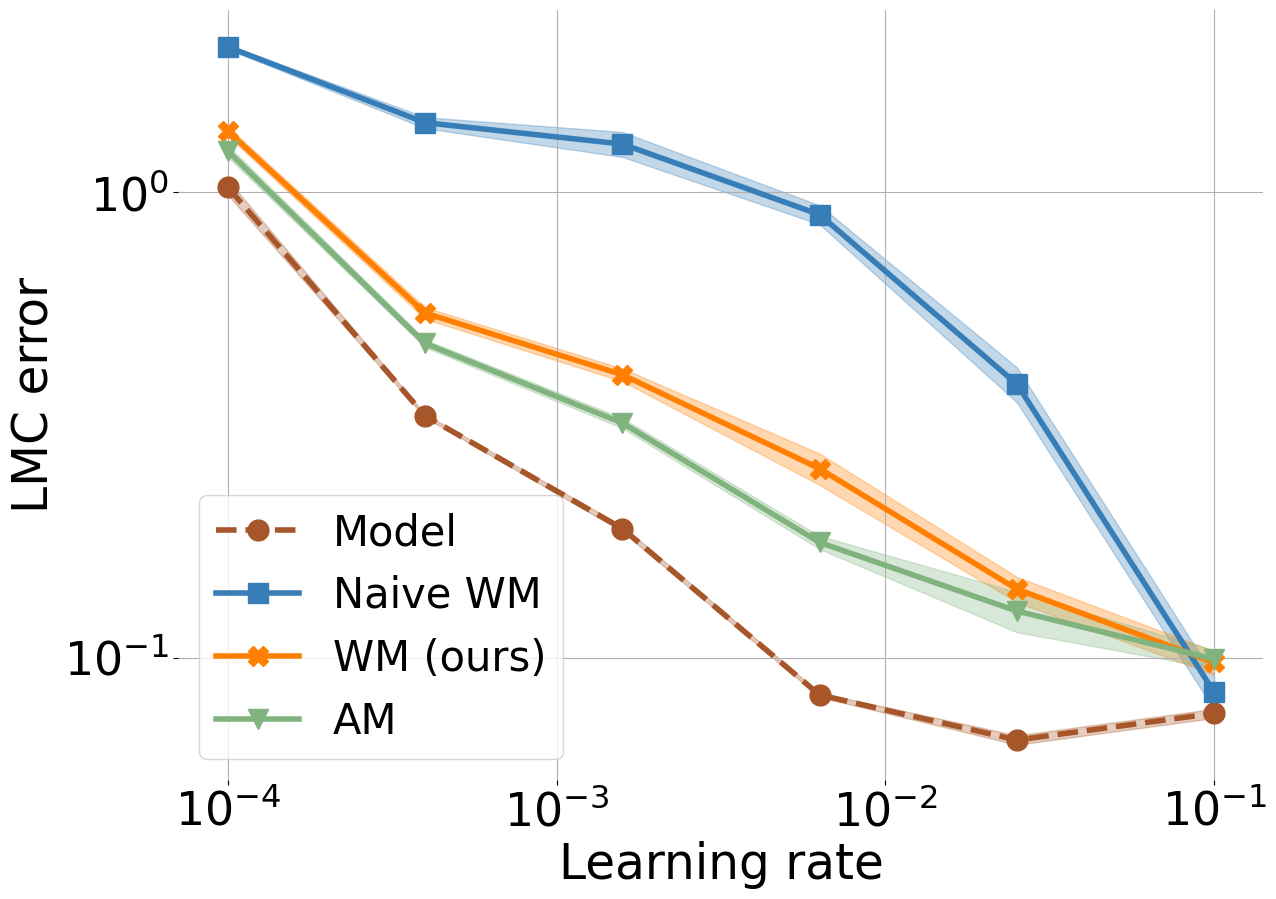

In [23]:
import matplotlib.pyplot as plt
from matplotlib.ticker import NullLocator
from matplotlib.patches import Rectangle


permuted_bumps_weight_matching_conditional_gradient1 = np.array([[d["bump_1_to_2perm_weight_matching_conditional_gradient1"] for d in stored_results_dict]for stored_results_dict in list_reps])
permuted_bumps_weight_matching_conditional_gradient2 = np.array([[d["bump_1_to_2perm_weight_matching_conditional_gradient2"] for d in stored_results_dict]for stored_results_dict in list_reps])
permuted_bumps_weight_matching_conditional_gradient3 = np.array([[d["bump_1_to_2perm_weight_matching_conditional_gradient3"] for d in stored_results_dict]for stored_results_dict in list_reps])
model1_loss = np.array([[d["model1_test_loss"] for d in stored_results_dict]for stored_results_dict in list_reps])
model2_loss = np.array([[d["model2_test_loss"] for d in stored_results_dict]for stored_results_dict in list_reps])

permuted_bumps_weight_matching_conditional_gradient1 = np.reshape(permuted_bumps_weight_matching_conditional_gradient1,[reps,-1])
permuted_bumps_weight_matching_conditional_gradient2 = np.reshape(permuted_bumps_weight_matching_conditional_gradient2,[reps,-1])
permuted_bumps_weight_matching_conditional_gradient3 = np.reshape(permuted_bumps_weight_matching_conditional_gradient3,[reps,-1])

model1_loss = np.reshape(model1_loss,[reps,-1])
model2_loss = np.reshape(model2_loss,[reps,-1])

def get_mean_and_error(vals):
  return np.mean(vals,axis=0), np.std(vals,axis=0)

mean_permuted_bumps_weight_matching_conditional_gradient1, error_permuted_bumps_weight_matching_conditional_gradient1 = get_mean_and_error(permuted_bumps_weight_matching_conditional_gradient1)
mean_permuted_bumps_weight_matching_conditional_gradient2, error_permuted_bumps_weight_matching_conditional_gradient2 = get_mean_and_error(permuted_bumps_weight_matching_conditional_gradient2)
mean_permuted_bumps_weight_matching_conditional_gradient3, error_permuted_bumps_weight_matching_conditional_gradient3 = get_mean_and_error(permuted_bumps_weight_matching_conditional_gradient3)

mean_model1_loss, error_model1_loss = get_mean_and_error(model1_loss)
mean_model2_loss, error_model2_loss = get_mean_and_error(model2_loss)


for i, width in enumerate(WIDTHs):
  fig,ax = plt.subplots(figsize = (14,10),dpi=100)
  fig.patch.set_facecolor('white')

  #plt.title(f"MNIST, MLP",fontsize=14)

  mean_permuted_bumps_weight_matching_conditional_gradient1_, error_permuted_bumps_weight_matching_conditional_gradient1_ =   mean_permuted_bumps_weight_matching_conditional_gradient1[i*len(LRs):(i+1)*len(LRs)], error_permuted_bumps_weight_matching_conditional_gradient1[i*len(LRs):(i+1)*len(LRs)]
  mean_permuted_bumps_weight_matching_conditional_gradient2_, error_permuted_bumps_weight_matching_conditional_gradient2_ =   mean_permuted_bumps_weight_matching_conditional_gradient2[i*len(LRs):(i+1)*len(LRs)], error_permuted_bumps_weight_matching_conditional_gradient2[i*len(LRs):(i+1)*len(LRs)]
  mean_permuted_bumps_weight_matching_conditional_gradient3_, error_permuted_bumps_weight_matching_conditional_gradient3_ =   mean_permuted_bumps_weight_matching_conditional_gradient3[i*len(LRs):(i+1)*len(LRs)], error_permuted_bumps_weight_matching_conditional_gradient3[i*len(LRs):(i+1)*len(LRs)]

  mean_model1_loss_, error_model1_loss_ = mean_model1_loss[i*len(LRs):(i+1)*len(LRs)], error_model1_loss[i*len(LRs):(i+1)*len(LRs)]
  mean_model2_loss_, error_model2_loss_ = mean_model2_loss[i*len(LRs):(i+1)*len(LRs)], error_model2_loss[i*len(LRs):(i+1)*len(LRs)]




  line, = plt.loglog(LRs[:len(mean_permuted_bumps_weight_matching_conditional_gradient1_)],(mean_model1_loss_+mean_model2_loss_)/2.0,marker="o",color=CB_color_cycle[4],linestyle="--",label="Model", linewidth=4, markersize=15)
  plt.fill_between(LRs[:len(mean_permuted_bumps_weight_matching_conditional_gradient1_)],(mean_model1_loss_+mean_model2_loss_)/2.0-(error_model1_loss_+error_model2_loss_)/2.0,(mean_model1_loss_+mean_model2_loss_)/2.0+(error_model1_loss_+error_model2_loss_)/2.0,color=line.get_color(),alpha=0.3)

  line, = plt.loglog(LRs[:len(mean_permuted_bumps_weight_matching_conditional_gradient1_)],mean_permuted_bumps_weight_matching_conditional_gradient1_,marker="s",color=CB_color_cycle[0],label='Naive WM', linewidth=4, markersize=15)
  plt.fill_between(LRs[:len(mean_permuted_bumps_weight_matching_conditional_gradient1_)],mean_permuted_bumps_weight_matching_conditional_gradient1_-error_permuted_bumps_weight_matching_conditional_gradient1_,mean_permuted_bumps_weight_matching_conditional_gradient1_+error_permuted_bumps_weight_matching_conditional_gradient1_,alpha=0.3,color=line.get_color())

  line, = plt.loglog(LRs[:len(mean_permuted_bumps_weight_matching_conditional_gradient1_)],mean_permuted_bumps_weight_matching_conditional_gradient2_,marker="X",color=CB_color_cycle[1],label='WM (ours)', linewidth=4, markersize=15)
  plt.fill_between(LRs[:len(mean_permuted_bumps_weight_matching_conditional_gradient1_)],mean_permuted_bumps_weight_matching_conditional_gradient2_-error_permuted_bumps_weight_matching_conditional_gradient2_,mean_permuted_bumps_weight_matching_conditional_gradient2_+error_permuted_bumps_weight_matching_conditional_gradient2_,alpha=0.3,color=line.get_color())

  line, = plt.loglog(LRs[:len(mean_permuted_bumps_weight_matching_conditional_gradient1_)],mean_permuted_bumps_weight_matching_conditional_gradient3_,marker="v",color=CB_color_cycle[2],label='AM', linewidth=4, markersize=15)
  plt.fill_between(LRs[:len(mean_permuted_bumps_weight_matching_conditional_gradient1_)],mean_permuted_bumps_weight_matching_conditional_gradient3_-error_permuted_bumps_weight_matching_conditional_gradient3_,mean_permuted_bumps_weight_matching_conditional_gradient3_+error_permuted_bumps_weight_matching_conditional_gradient3_,alpha=0.3,color=line.get_color())

  plt.xticks(fontsize=33)
  plt.yticks(fontsize=33)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)
  plt.grid(True)
  ax.xaxis.set_minor_locator(NullLocator())
  ax.yaxis.set_minor_locator(NullLocator())

  plt.xlabel("Learning rate",fontsize=35)
  plt.ylabel("LMC error",fontsize=35)
  plt.legend(fontsize=30)
  plt.savefig('sample_data/professional.pdf',bbox_inches='tight')
  plt.show()

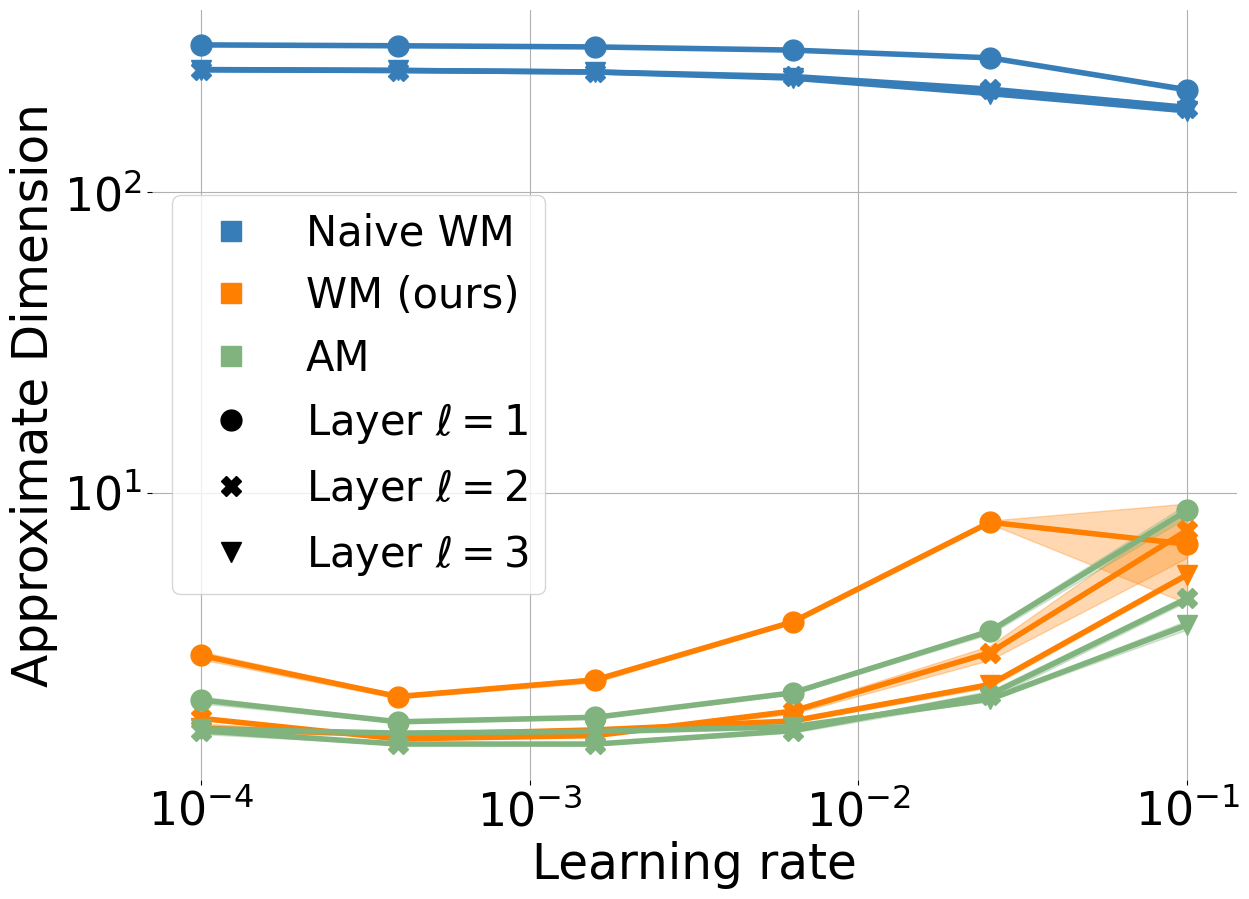

In [24]:
arr= np.array([[d["approx_dimensions"] for d in stored_results_dict] for stored_results_dict in list_reps])
mean_arr, error_arr=get_mean_and_error(arr)
dic_color={'1':'#377eb8','2':'#ff7f00','3':'#80B37E'}
dic_marker={'0':'o','1':'X','2':'v'}
colors=['#377eb8','#ff7f00','#80B37E']
markers=['o','X','v']
dic_method={0:'Naive WM', 1:'WM (ours)',2:'AM'}
fig,ax = plt.subplots(figsize = (14,10),dpi=100)
fig.patch.set_facecolor('white')
for method in range(mean_arr.shape[1]):
  for layer in range(mean_arr.shape[2]):
    if layer == 0:
      line, = plt.loglog(LRs[:len(mean_permuted_bumps_weight_matching_conditional_gradient1_)],mean_arr[:,method,layer],marker=dic_marker[f'{layer}'],color=dic_color[f'{method+1}'],label=dic_method[method], linewidth=4, markersize=15)

      plt.fill_between(LRs[:len(mean_permuted_bumps_weight_matching_conditional_gradient1_)],mean_arr[:,method,layer]-error_arr[:,method,layer],mean_arr[:,method,layer]+error_arr[:,method,layer],alpha=0.3,color=line.get_color())
    else:
      line, = plt.loglog(LRs[:len(mean_permuted_bumps_weight_matching_conditional_gradient1_)],mean_arr[:,method,layer],marker=dic_marker[f'{layer}'],color=dic_color[f'{method+1}'], linewidth=4, markersize=15)


      plt.fill_between(LRs[:len(mean_permuted_bumps_weight_matching_conditional_gradient1_)],mean_arr[:,method,layer]-error_arr[:,method,layer],mean_arr[:,method,layer]+error_arr[:,method,layer],alpha=0.3,color=line.get_color())

plt.xlabel("Learning rate",fontsize=35)
plt.ylabel("Approximate Dimension",fontsize=35)
plt.xticks(fontsize=33)
plt.yticks(fontsize=33)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.grid(True)
ax.xaxis.set_minor_locator(NullLocator())
ax.yaxis.set_minor_locator(NullLocator())

f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none",markersize=15)[0]

handles = [f("s", colors[i]) for i in range(3)]
handles += [f(markers[i], "k") for i in range(3)]

labels = ['Naive WM','WM (ours)','AM'] + ["Layer "+r"$\ell=1$", "Layer "+r"$\ell=2$","Layer "+r"$\ell=3$"]

plt.legend(handles, labels, fontsize=30)

plt.savefig('professional_approx_dim.pdf',bbox_inches='tight')
plt.show()

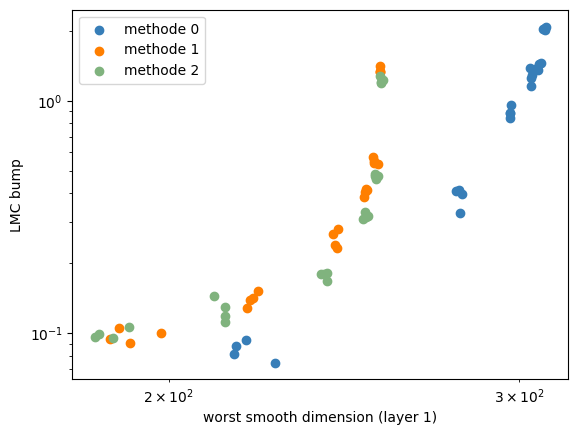

In [25]:
L_x,L_y=[[],[],[]],[[],[],[]]
for lr in range(6):
  for layer in range(1):
    for method in range(3):
      if method==0:
        bump=permuted_bumps_weight_matching_conditional_gradient1[:,lr]
      elif method==1:
        bump=permuted_bumps_weight_matching_conditional_gradient2[:,lr]
      elif method==2:
        bump=permuted_bumps_weight_matching_conditional_gradient3[:,lr]
      L_x[method]+=arr[:,lr,layer,method].tolist()
      L_y[method]+=bump.tolist()
for method in range(3):
  plt.scatter(L_x[method],L_y[method], color=dic_color[f'{method+1}'],label=f'methode {method}')
  plt.xlabel('worst smooth dimension (layer 1)')
  plt.ylabel('LMC bump')
  plt.xscale('log')
  plt.yscale('log')
plt.legend()